In [141]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import os
import math
from matplotlib import pyplot as plt 

blockSize=1024
hopSize=512
fs=44100

In [142]:
from scipy.io.wavfile import read as wavread
def ToolReadAudio(cAudioFilePath):    
    [samplerate, x] = wavread(cAudioFilePath)    
    if x.dtype == 'float32':        
        audio = x    
    else:        
        # change range to [-1,1)        
        if x.dtype == 'uint8':            
            nbits = 8        
        elif x.dtype == 'int16':            
            nbits = 16        
        elif x.dtype == 'int32':            
            nbits = 32        
        audio = x / float(2**(nbits - 1))    
        # special case of unsigned format    
    if x.dtype == 'uint8':        
        audio = audio - 1.    
    return (samplerate, audio)

In [143]:
fs,x = ToolReadAudio('../assignment_1/trainData/01-D_AMairena.wav')

<ipython-input-142-70eaf167f057>:3: WavFileWarning:

Chunk (non-data) not understood, skipping it.



In [144]:
# BLOCK AUDIO
def block_audio(x,blockSize,hopSize,fs):    
    # allocate memory    
    numBlocks = math.ceil(x.size / hopSize)    
    xb = np.zeros([numBlocks, blockSize])    
    # compute time stamps    
    t = (np.arange(0, numBlocks) * hopSize) / fs   
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)    
    for n in range(0, numBlocks):        
        i_start = n * hopSize        
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])        
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]    
    return (xb,t)

In [145]:
xb,t = block_audio(x, blockSize, hopSize, fs)

## Test signals

In [7]:
test_aud = np.sin(2*np.pi*1000*np.arange(1 * fs)/fs)
test_blocked,t = block_audio(test_aud,2048, 1024, fs)
print(math.ceil(test_aud.size / 1024))

44


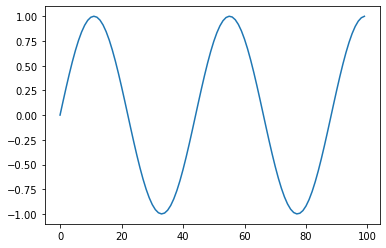

In [86]:
plt.plot(test_aud[0:100])

## Calculate STFT from blocked audio

In [53]:
xb.shape

(2224, 1024)

In [62]:
block = xb[0]
freq=np.fft.fftfreq(block.size,1/fs)
freq[:int(block.size/2)].shape

(512,)

In [376]:
def calc_stft(xb,fs=44100):
    stft = np.zeros((xb.shape[0],(int(xb[0].shape[0]/2)+1)))
    freqs = np.zeros((xb.shape[0],(int(xb[0].shape[0]/2)+1)))
    window = np.hanning(xb[0].shape[0])
    for i in range(xb.shape[0]):
        block= xb[i]
        # Apply Window to the block
        windowed_block = window * block 
        stft_blk = np.fft.fft(windowed_block)
        #stft_blk = np.fft.rfft(windowed_block)
        freq=np.fft.fftfreq(block.size,1/fs)
        freqs[i]=freq[:int(block.size/2)+1]
        stft_blk = np.abs(stft_blk)
        #stft_block = stft_blk[int((stft_blk.shape[0])/2):]
        stft_block = stft_blk[:int(((stft_blk.shape[0])/2)+1)]
        stft_db = 10*np.log10(stft_block) # IS THIS CORRECT??
        stft[i]=stft_block#stft_db
    stft = np.array(stft)
    freqs=np.array(freqs)
    return stft,freqs

In [377]:
stft,freqs = calc_stft(xb,44100)


In [330]:
stft.shape

(2224, 513)

In [43]:
window = np.hanning(xb[0].shape[0])
import plotly.express as px
px.line(window)

In [374]:
def plot_spectrogram(spectrogram, fs, hopSize):
    t = hopSize*np.arange(spectrogram.shape[0])/fs
    f = np.arange(0,fs/2, fs/2/spectrogram.shape[1])

    plt.figure(figsize = (15, 7))
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.pcolormesh(t, f, spectrogram.T)
    plt.show()

<ipython-input-374-f35a1e257f57>:8: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



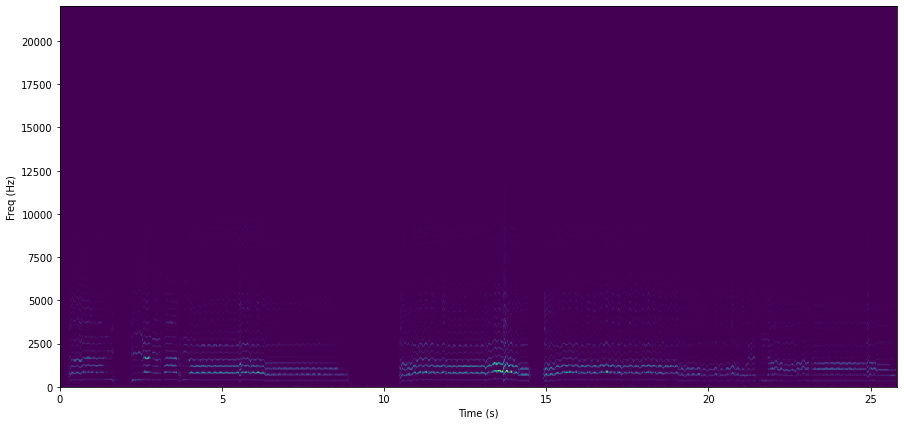

In [378]:
plot_spectrogram(stft,44100,512)

In [333]:
freqs[1]

array([     0.        ,     43.06640625,     86.1328125 ,    129.19921875,
          172.265625  ,    215.33203125,    258.3984375 ,    301.46484375,
          344.53125   ,    387.59765625,    430.6640625 ,    473.73046875,
          516.796875  ,    559.86328125,    602.9296875 ,    645.99609375,
          689.0625    ,    732.12890625,    775.1953125 ,    818.26171875,
          861.328125  ,    904.39453125,    947.4609375 ,    990.52734375,
         1033.59375   ,   1076.66015625,   1119.7265625 ,   1162.79296875,
         1205.859375  ,   1248.92578125,   1291.9921875 ,   1335.05859375,
         1378.125     ,   1421.19140625,   1464.2578125 ,   1507.32421875,
         1550.390625  ,   1593.45703125,   1636.5234375 ,   1679.58984375,
         1722.65625   ,   1765.72265625,   1808.7890625 ,   1851.85546875,
         1894.921875  ,   1937.98828125,   1981.0546875 ,   2024.12109375,
         2067.1875    ,   2110.25390625,   2153.3203125 ,   2196.38671875,
         2239.453125  ,  

In [327]:
import plotly.express as px
spectrogram,freqs = calc_stft(xb)
# import pandas as pd
# stft,freqs = calc_stft(test_blocked,44100)
# df = pd.DataFrame()
# df['stft']=stft[0]
# df['freqs']=freqs[0]
fig = px.line(x=freqs[0],y=spectrogram[0])#df,x='freqs',y='stft')
fig.show()

In [83]:
spectrogram,freqs = calc_stft(xb)

# Section A

## Q1: 
### Implement functions for 5 audio features: extract_spectral_centroid(xb, fs), extract_rms(xb), extract_zerocrossingrate(xb), extract_spectral_crest(xb), extract_spectral_flux(xb). xb is a matrix of blocked audio data (dimension NumOfBlocks X blockSize, see assignment 1), fs is the sample rate. Implement each of these functions in the default formulation from the text book/slides. Note that for the spectral features, you have to apply a window function to each block. Use the hann window from a previous in-class exercise for this purpose. To avoid feature definition ambiguities:
    1. Spectral Centroid in Hz, compute from the magnitude spectrum (not power spectrum)
    2. RMS in dB, truncated at -100dB
    3. all others as defined in the book

## Spectral Centroid

In [384]:
freqs[0]

array([     0.        ,     43.06640625,     86.1328125 ,    129.19921875,
          172.265625  ,    215.33203125,    258.3984375 ,    301.46484375,
          344.53125   ,    387.59765625,    430.6640625 ,    473.73046875,
          516.796875  ,    559.86328125,    602.9296875 ,    645.99609375,
          689.0625    ,    732.12890625,    775.1953125 ,    818.26171875,
          861.328125  ,    904.39453125,    947.4609375 ,    990.52734375,
         1033.59375   ,   1076.66015625,   1119.7265625 ,   1162.79296875,
         1205.859375  ,   1248.92578125,   1291.9921875 ,   1335.05859375,
         1378.125     ,   1421.19140625,   1464.2578125 ,   1507.32421875,
         1550.390625  ,   1593.45703125,   1636.5234375 ,   1679.58984375,
         1722.65625   ,   1765.72265625,   1808.7890625 ,   1851.85546875,
         1894.921875  ,   1937.98828125,   1981.0546875 ,   2024.12109375,
         2067.1875    ,   2110.25390625,   2153.3203125 ,   2196.38671875,
         2239.453125  ,  

In [10]:
#using numpy array instead of list
#Done with frequency bin, not Hz
def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
        centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids

### Testing spectral centroid

Text(0.5, 1.0, 'Signal vs Normalized spectral centroid')

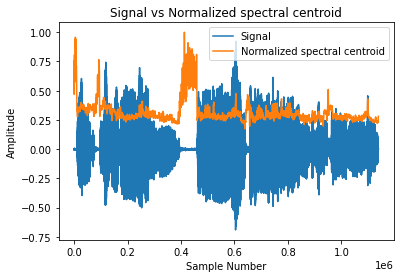

In [20]:
centroid = extract_spectral_centroid(xb,44100)
centroid=centroid/max(centroid)
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,centroid)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized spectral centroid'])
plt.title('Signal vs Normalized spectral centroid')

Alex's Version

Text(0.5, 1.0, 'Signal vs Normalized spectral centroid')

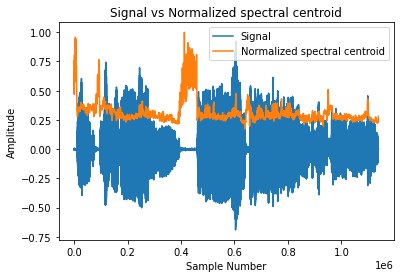

In [235]:
X,f = calc_stft(xb,44100)
X=X.T
centroid = pyACA.FeatureSpectralCentroid(X,44100)#extract_spectral_centroid(xb,44100)
centroid=centroid/max(centroid)
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,centroid)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized spectral centroid'])
plt.title('Signal vs Normalized spectral centroid')

## RMS

In [246]:
def extract_rms(xb):
    rms = np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        block = xb[i]
        r = np.sqrt(np.sum(block**2)/xb.shape[0])
        if r <= 0.00001: # Done to handle case when rms is 0 (for a block of all zeros
            r = 0.00001
        #rms.append(r)
        rms[i] = r
    #rms=np.array(rms)
    return 20*np.log10(rms)#rms,20*np.log10(rms) # What is reference value to convert to dB? Is it 1?

### Testing rms

In [154]:
extract_rms(xb).shape

(2224,)

0.0007398458364183605


Text(0.5, 1.0, 'Signal vs RMS')

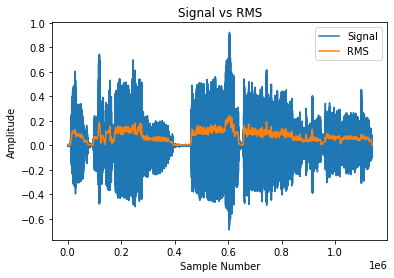

In [84]:
def extract_rms_raw(xb):
    rms=[]
    for block in xb:
        r = np.sqrt(np.sum(block**2)/xb.shape[0])
        if r <= 0.00001: # Done to handle case when rms is 0 (for a block of all zeros
            r = 0.00001
        
        rms.append(r)
    rms=np.array(rms)
    return rms#rms,20*np.log10(rms) # What is reference value to convert to dB? Is it 1?
rms = extract_rms_raw(xb)
print(rms.min())
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,rms)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','RMS'])
plt.title('Signal vs RMS')

-62.61717531802516


Text(0.5, 1.0, 'Signal vs RMS')

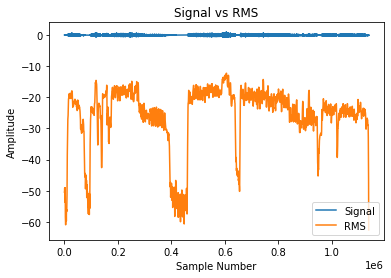

In [247]:
rms = extract_rms(xb)
print(rms.min())
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,rms)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','RMS'])
plt.title('Signal vs RMS')

Alex's Version

Text(0.5, 1.0, 'Signal vs RMS')

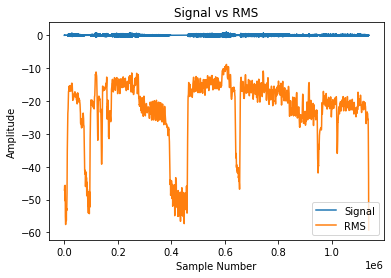

In [242]:
# allocate memory
vrms = np.zeros(2224)

for n, block in enumerate(xb):
    # calculate the rms
    vrms[n] = np.sqrt(np.dot(block, block) / block.size)

# convert to dB
epsilon = 1e-5  # -100dB

vrms[vrms < epsilon] = epsilon
vrms = 20 * np.log10(vrms)

#rms,t = pyACA.FeatureTimeRms(x,blockSize,hopSize,fs)#extract_rms_raw(xb)
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,vrms)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','RMS'])
plt.title('Signal vs RMS')

## ZCR

In [206]:
def extract_zerocrossingrate(xb):
    zcr= np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        block = xb[i]
        zero_crossings = np.sum(np.abs(np.diff(np.sign(block)))) / block.shape[0] #np.nonzero(np.diff(block > 0))[0].size
        #zcr.append(zero_crossings)
        zcr[i] = zero_crossings 
    #zcr = np.array(zcr)
    return zcr

### Testing ZCR

Text(0.5, 1.0, 'Signal vs Normalized ZCR')

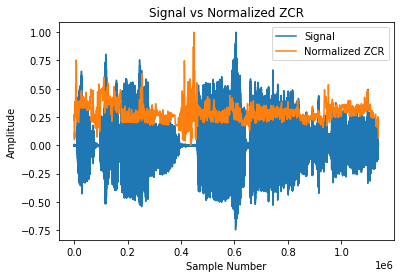

In [129]:
def extract_zerocrossingrate_test(xb):
    zcr1=[]
    zcr2=[]
    for block in xb:
        zero_crossings = np.sum(np.abs(np.diff(np.sign(block)))) / block.shape[0] #np.nonzero(np.diff(block > 0))[0].size
        zcr1.append(zero_crossings)
        zcr2.append(0.5 * np.mean(np.abs(np.diff(np.sign(block)))))
    zcr1 = np.array(zcr1)
    zcr2=np.array(zcr2)
    return zcr1,zcr2

zcr1,zcr2 = extract_zerocrossingrate_test(xb)
zcr_plt = zcr1/max(zcr1)
t_zcr = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_zcr,zcr_plt)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized ZCR'])
plt.title('Signal vs Normalized ZCR')

Alex's Version

Text(0.5, 1.0, 'Signal vs Normalized ZCR')

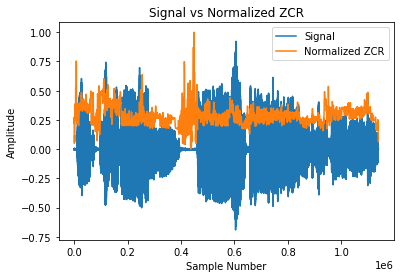

In [250]:
# number of results
iNumOfBlocks = xb.shape[0]

# compute time stamps
t = (np.arange(0, iNumOfBlocks) * hopSize + (blockSize / 2)) / fs

# allocate memory
vzc = np.zeros(iNumOfBlocks)

for n, block in enumerate(xb):
    # calculate the zero crossing rate
    vzc[n] = 0.5 * np.mean(np.abs(np.diff(np.sign(block))))

t_zcr = np.arange(0,xb.shape[0])*hopSize
zcr_plt = vzc
plt.plot(x)
plt.plot(t_zcr,zcr_plt/max(zcr_plt))

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized ZCR'])
plt.title('Signal vs Normalized ZCR')

## Spectral Crest

In [207]:
def extract_spectral_crest(xb):
    crest = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,44100)
    for i in range(stft.shape[0]):
        #crest.append((np.max(stft[i])/np.sum(stft[i])))
        crest[i] = np.max(stft[i])/np.sum(stft[i])
    #crest = np.array(crest)
    return crest

### Testing Spectral Crest

In [167]:
extract_spectral_crest(xb).shape

(2224,)

Text(0.5, 1.0, 'Signal vs Normalized spectral crest')

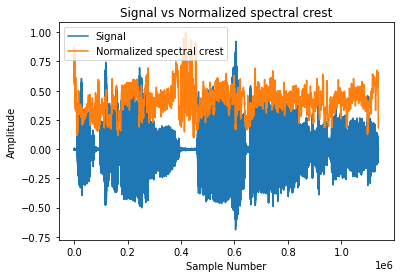

In [46]:
crest = extract_spectral_crest(xb)
crest=crest/max(crest)
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,crest)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized spectral crest'])
plt.title('Signal vs Normalized spectral crest')

Alex's Version

Text(0.5, 1.0, 'Signal vs Normalized spectral crest')

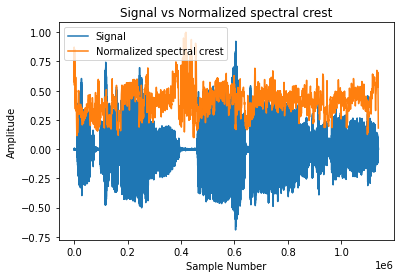

In [252]:
X,f=calc_stft(xb,44100)
X=X.T
crest = pyACA.FeatureSpectralCrestFactor(X,fs)
crest=crest/max(crest)
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,crest)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized spectral crest'])
plt.title('Signal vs Normalized spectral crest')

## Spectral Flux

In [208]:
def extract_spectral_flux(xb):
    num_blocks=xb.shape[0] 
    blockSize = xb.shape[1]
    spectral_flux = np.zeros(num_blocks)
    stft,freqs = calc_stft(xb,44100)
    fft_len= stft.shape[1]
    n = 0
    k = 0
    for n in range(1,num_blocks):
        sum_flux = 0
        for k in range(fft_len):
            f = (abs(stft[n, k]) - abs(stft[n-1, k]))**2
            sum_flux += f
        flux = np.sqrt(sum_flux)/((blockSize/2)+1)
        spectral_flux[n] = flux #first flux value will be 0
    return spectral_flux

In [190]:
# ########### BAD, DONT USE
# def extract_spectral_flux(xb):
#     num_blocks=xb.shape[0] 
#     flux = np.zeros(xb.shape[0])
#     stft,freqs = calc_stft(xb,44100)
#     for i in range(int(stft.shape[0])):
#         dff=np.diff(stft[i].T)
#         dff_sq=dff**2
#         flx = np.sqrt(np.sum(dff_sq))
#         #flux.append(flx/(xb.shape[0]+1))
#         flux[i] = flx/(xb.shape[1]+1)
#     #flux = np.array(flux)
#     return(flux)

### Testing Spectral Flux

Text(0.5, 1.0, 'Signal vs Normalized spectral flux')

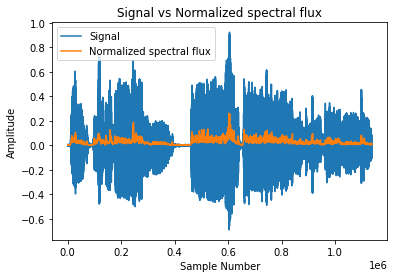

In [200]:
flux = extract_spectral_flux(xb)
#flux=flux/max(flux)
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,flux)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized spectral flux'])
plt.title('Signal vs Normalized spectral flux')

Alex's Version

Text(0.5, 1.0, 'Signal vs Normalized spectral flux')

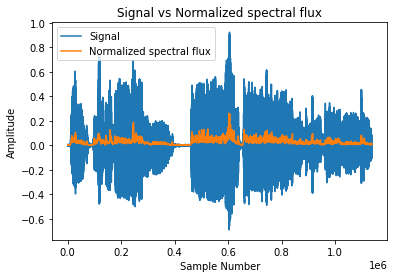

In [254]:
X,f=calc_stft(xb,44100)
X=X.T
flux1 = pyACA.FeatureSpectralFlux(X,44100)
#flux=flux/max(flux)
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,flux1)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized spectral flux'])
plt.title('Signal vs Normalized spectral flux')

## Q2:
### Implement a function: [features] = extract_features(x, blockSize, hopSize, fs) This function serves as a wrapper for feature extraction. It will take a single-channel audio vector x as input, blocks the audio with the given block size and hop size using block_audio(), calls each of the feature extractor functions implemented above and returns a 5 X NumOfBlocks dimensional feature matrix.

In [209]:
def extract_features(x, blockSize, hopSize, fs):
    xb,ts = block_audio(x,blockSize,hopSize,fs)
    features=np.zeros((5,xb.shape[0]))
    features[0] = extract_spectral_centroid(xb,fs)
    features[1] = extract_rms(xb)
    features[2] = extract_zerocrossingrate(xb)
    features[3] = extract_spectral_crest(xb)
    features[4] = extract_spectral_flux(xb)
    return features

In [210]:
extract_features(x,blockSize,hopSize,fs).shape

(5, 2224)

In [211]:
features = extract_features(x,blockSize,hopSize,fs)

## Q3:
### Implement a function: [aggFeatures] = aggregate_feature_per_file(features). This function aggregates the feature matrix returned by extract_features(), aggregates the features across blocks using mean and standard deviation and returns a  10x1 aggregated feature matrix

In [212]:
def aggregate_feature_per_file(features):
    agg_features = np.zeros((2*features.shape[0],1))
    agg_features[0]= np.mean(features[0])
    agg_features[1]= np.std(features[0])
    agg_features[2]= np.mean(features[1])
    agg_features[3]= np.std(features[1])
    agg_features[4]= np.mean(features[2])
    agg_features[5]= np.std(features[2])
    agg_features[6]= np.mean(features[3])
    agg_features[7]= np.std(features[3])
    agg_features[8]= np.mean(features[4])
    agg_features[9]= np.std(features[4])
    return agg_features

In [213]:
featureData=aggregate_feature_per_file(features)

## Q4:
### Implement a  function: [featureData] = get_feature_data(path, blockSize, hopSize) This function loops over all files contained within a folder that is pointed to by the path argument. The function will then successively call the extract_features() and aggregate_feature_per_file() functions and return a 10xN feature matrix of which contains the aggregated features for N audio files contained in the directory.

In [216]:
path='resources/music_speech/music_wav/'

In [214]:
def get_feature_data(path, blockSize, hopSize):
    N=0
    i=0
    for file_name in os.listdir(path):
        if file_name.endswith(".wav"):
            N+=1
    featureData=np.zeros((10,N))
    for file_name in os.listdir(path):
        if file_name.endswith(".wav"):
            #print(file_name)
            fs,x = ToolReadAudio(path+file_name)
            features = extract_features(x,blockSize,hopSize,fs)
            aggFeatures = aggregate_feature_per_file(features)
            for j in range(10):
                featureData[j][i] = aggFeatures[j]
            i+=1
    return featureData


In [217]:
featureData = get_feature_data(path, blockSize, hopSize)

In [223]:
featureData.shape

(10, 64)

# Section B:
## Q1: 
### Implement a  function: [normFeatureMatrix] = normalize_zscore(featureData) This function applies the z-score normalization scheme to the input feature matrix. The z-score normalization normalizes each feature to a zero mean and unit standard deviation across the entire dataset. Be careful with the dimensions.

## Z-Score Normalization

In [224]:
def normalize_zscore(featureData):
    normalized_matrix = np.zeros((featureData.shape[0],featureData.shape[1]))
    for i in range(featureData.shape[0]):
        std = np.std(featureData[i])
        mean = np.mean(featureData[i])
        normalized_matrix[i] = (featureData[i]-mean)/std
    return normalized_matrix

In [234]:
norm=normalize_zscore(featureData)
np.std(norm[4])

0.9999999999999999

# Section C
## Q1
Implement a function visualize_features(path_to_musicspeech) that extracts 2 separate feature matrices for the files in each of the folder (music and speech). You will call your get_feature_data() function for that with blockSize = 1024 and hopSize = 256. You will also normalize the feature matrices over the entire dataset. Note that this means you have to normalize both feature matrices with the same z-score. (hint: concatenate the two feature matrices appropriately before calling normalize_zscore())

In [259]:
path = "resources/music_speech/"

In [256]:
def visualize_features(path):
    blockSize = 1024
    hopSize = 256
    audio = get_feature_data(path+'music_wav/',blockSize,hopSize)
    speech = get_feature_data(path+'speech_wav/',blockSize,hopSize)
    combo=np.append(music,speech,axis=1)
    combo_normalized = normalize_zscore(combo)

    music_normalized = combo_normalized[:,:music.shape[1]]
    speech_normalized = combo_normalized[:,music.shape[1]:music.shape[1]+speech.shape[1]]


In [262]:
music=get_feature_data(path+'music_wav/',blockSize,hopSize)
music.shape[1]

64

In [280]:
music_resplit=combo[:,:music.shape[1]] 
music_resplit== music
speech_resplit=combo[:,music.shape[1]:music.shape[1]+speech.shape[1]] 
speech_resplit== speech

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  Tru

# Q2
Within the same function write code that generates plots to visualize the feature space of the following 5 pairs of features: [SC mean, SCR mean], [SF mean, ZCR mean], [RMS mean, RMS std], [ZCR std, SCR std], [SC std, SF std] Note that you want to plot the data points corresponding to music with a different color than the points that correspond to speech. Use red for music and blue for speech. This type of visualization is referred to as scatter plot. What can you infer from these scatter plots?

Index : Feature
- 0 : Centroid Mean
- 1 : Centroid Std
- 2 : RMS Mean
- 3 : RMS Std
- 4 : ZCR Mean
- 5 : ZCR Std
- 6 : Crest Mean
- 7 : Crest Std
- 8 : Flux Mean
- 9 : Flux Std

In [311]:
path

'resources/music_speech/'

In [312]:
def visualize_features(path):
    blockSize = 1024
    hopSize = 256
    music = get_feature_data(path+'music_wav/',blockSize,hopSize)
    speech = get_feature_data(path+'speech_wav/',blockSize,hopSize)
    combo=np.concatenate([music,speech],axis=1)
    combo_normalized = normalize_zscore(combo)

    music_normalized = combo_normalized[:,:music.shape[1]]
    speech_normalized = combo_normalized[:,music.shape[1]:music.shape[1]+speech.shape[1]]

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 15))
    ax1 = fig.add_subplot(511)
    ax2 = fig.add_subplot(512)
    ax3 = fig.add_subplot(513)
    ax4 = fig.add_subplot(514)
    ax5 = fig.add_subplot(515)

    #Plot 1
    ax1.scatter(music_resplit[0],music_resplit[6],color='red')
    ax1.scatter(speech_resplit[0],speech_resplit[6],color='blue')

    #Plot 2
    ax2.scatter(music_resplit[8],music_resplit[4],color='red')
    ax2.scatter(speech_resplit[8],speech_resplit[4],color='blue')

    #Plot 3
    ax3.scatter(music_resplit[2],music_resplit[3],color='red')
    ax3.scatter(speech_resplit[2],speech_resplit[3],color='blue')

    #Plot 4
    ax4.scatter(music_resplit[5],music_resplit[7],color='red')
    ax4.scatter(speech_resplit[5],speech_resplit[7],color='blue')

    #Plot 5
    ax5.scatter(music_resplit[1],music_resplit[9],color='red')
    ax5.scatter(speech_resplit[1],speech_resplit[9],color='blue')

    #Labelling axes and plots
    ax1.set_xlabel('Spectral Centroid Mean')
    ax1.set_ylabel('Spectral Crest Mean')
    ax1.set_title('SC Mean vs SCR Mean')

    ax2.set_xlabel('Spectral Flux Mean')
    ax2.set_ylabel('Zero Crossing Rate Mean')
    ax2.set_title('SF Mean vs ZCR Mean')

    ax3.set_xlabel('RMS Mean')
    ax3.set_ylabel('RMS Standard Deviation')
    ax3.set_title('RMS Mean vs RMS Std')

    ax4.set_xlabel('ZCR Standard Deviation')
    ax4.set_ylabel('Spectral Crest Standard Deviation')
    ax4.set_title('ZCR Std vs SCR Std')

    ax5.set_xlabel('Spectral Centroid Standard Deviation')
    ax5.set_ylabel('Spectral Flux Standard Deviation')
    ax5.set_title('SC Std vs SF Std')


    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=1.2, 
                        wspace=0.4, 
                        hspace=0.4)
    fig.show()

In [318]:
visualize_features('./resources/music_speech/')

KeyboardInterrupt: 

<ipython-input-350-febcb5c82596>:60: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



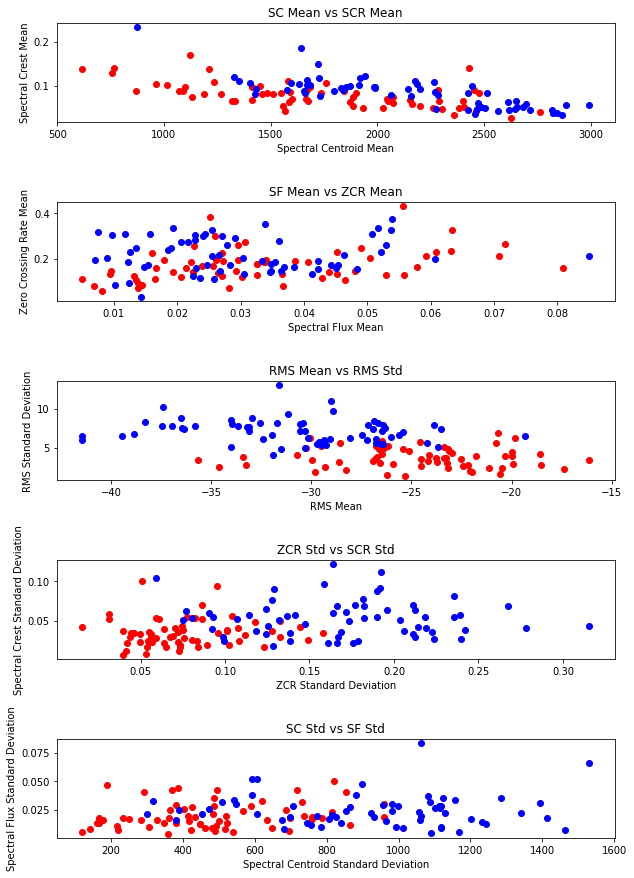

In [350]:
combo=np.concatenate([music,speech],axis=1)
combo_normalized = normalize_zscore(combo)

music_normalized = combo_normalized[:,:music.shape[1]]
speech_normalized = combo_normalized[:,music.shape[1]:music.shape[1]+speech.shape[1]]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

#Plot 1
ax1.scatter(music_resplit[0],music_resplit[6],color='red')
ax1.scatter(speech_resplit[0],speech_resplit[6],color='blue')

#Plot 2
ax2.scatter(music_resplit[8],music_resplit[4],color='red')
ax2.scatter(speech_resplit[8],speech_resplit[4],color='blue')

#Plot 3
ax3.scatter(music_resplit[2],music_resplit[3],color='red')
ax3.scatter(speech_resplit[2],speech_resplit[3],color='blue')

#Plot 4
ax4.scatter(music_resplit[5],music_resplit[7],color='red')
ax4.scatter(speech_resplit[5],speech_resplit[7],color='blue')

#Plot 5
ax5.scatter(music_resplit[1],music_resplit[9],color='red')
ax5.scatter(speech_resplit[1],speech_resplit[9],color='blue')

#Labelling axes and plots
ax1.set_xlabel('Spectral Centroid Mean')
ax1.set_ylabel('Spectral Crest Mean')
ax1.set_title('SC Mean vs SCR Mean')

ax2.set_xlabel('Spectral Flux Mean')
ax2.set_ylabel('Zero Crossing Rate Mean')
ax2.set_title('SF Mean vs ZCR Mean')

ax3.set_xlabel('RMS Mean')
ax3.set_ylabel('RMS Standard Deviation')
ax3.set_title('RMS Mean vs RMS Std')

ax4.set_xlabel('ZCR Standard Deviation')
ax4.set_ylabel('Spectral Crest Standard Deviation')
ax4.set_title('ZCR Std vs SCR Std')

ax5.set_xlabel('Spectral Centroid Standard Deviation')
ax5.set_ylabel('Spectral Flux Standard Deviation')
ax5.set_title('SC Std vs SF Std')


plt.subplots_adjust(
                    wspace=0.5, 
                    hspace=0.8)
fig.show()

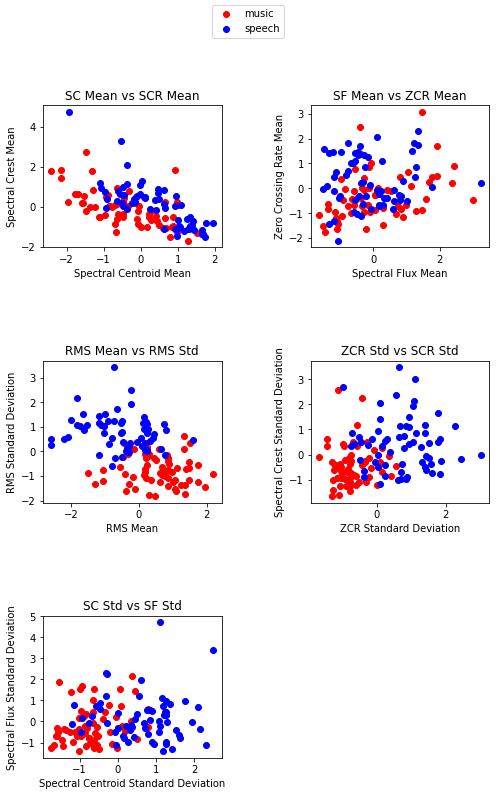

In [368]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 12))

# ax1 = fig.add_subplot(511)
# ax2 = fig.add_subplot(512)
# ax3 = fig.add_subplot(513)
# ax4 = fig.add_subplot(514)
# ax5 = fig.add_subplot(515)
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

#Plot 1
ax1.scatter(music_normalized[0],music_normalized[6],color='red')
ax1.scatter(speech_normalized[0],speech_normalized[6],color='blue')

#Plot 2
ax2.scatter(music_normalized[8],music_normalized[4],color='red')
ax2.scatter(speech_normalized[8],speech_normalized[4],color='blue')

#Plot 3
ax3.scatter(music_normalized[2],music_normalized[3],color='red')
ax3.scatter(speech_normalized[2],speech_normalized[3],color='blue')

#Plot 4
ax4.scatter(music_normalized[5],music_normalized[7],color='red')
ax4.scatter(speech_normalized[5],speech_normalized[7],color='blue')

#Plot 5
ax5.scatter(music_normalized[1],music_normalized[9],color='red')
ax5.scatter(speech_normalized[1],speech_normalized[9],color='blue')

#Labelling axes and plots
ax1.set_xlabel('Spectral Centroid Mean')
ax1.set_ylabel('Spectral Crest Mean')
ax1.set_title('SC Mean vs SCR Mean')

ax2.set_xlabel('Spectral Flux Mean')
ax2.set_ylabel('Zero Crossing Rate Mean')
ax2.set_title('SF Mean vs ZCR Mean')

ax3.set_xlabel('RMS Mean')
ax3.set_ylabel('RMS Standard Deviation')
ax3.set_title('RMS Mean vs RMS Std')

ax4.set_xlabel('ZCR Standard Deviation')
ax4.set_ylabel('Spectral Crest Standard Deviation')
ax4.set_title('ZCR Std vs SCR Std')

ax5.set_xlabel('Spectral Centroid Standard Deviation')
ax5.set_ylabel('Spectral Flux Standard Deviation')
ax5.set_title('SC Std vs SF Std')

fig.legend(['music','speech'],loc='upper center')
plt.subplots_adjust( 
                    wspace=0.5, 
                    hspace=0.8)

plt.show()